In [110]:
import torch
import numpy as np
# from tqdm import tqdm
from tqdm.notebook import tqdm_notebook as tqdm
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import utilityfuc

import numpy as np
from scipy import stats

use_gpu = False  # set it to True to use GPU and False to use CPU

if use_gpu:
    torch.cuda.set_device(0)

#%% System Parameters
# 1. Mini batch size
mb_size = 32
# 2. Missing rate
p_miss = 0.5
# 3. Hint rate
p_hint = 0.9
# 4. Loss Hyperparameters
alpha = 10
# 5. Train Rate
train_rate = 0.8


In [13]:
def introduce_mising(X):
    N, D = X.shape
    Xnan = X.copy()

    mask = np.ones(X.shape)
    # ---- MNAR in D/2 dimensions
    q2 = np.median(Xnan[:, :int(D)], axis=0)
    #print(q2)
    
    ix_larger_than_mean = 1- (Xnan[:, :int(D)] > q2)

    mask[:, :int(D)] = ix_larger_than_mean

    return mask


def apply_mask(observed_values, gt_masks):
    missing_values = observed_values.copy()
    missing_values[gt_masks == 0] = np.nan
    return missing_values

In [184]:
#name  = sys.argv[1]

# coef = float(sys.argv[2])
# spam
dataset_file = 'Spam.csv'  
#dataset_file = "Letter.csv"
#dataset_file = "data_banknote_authentication.txt"
#%% Data

# Data generation
Data = np.loadtxt(dataset_file, delimiter=",",skiprows=1)

label = Data[:,-1]
Data = Data[:,:-1]

In [185]:
# Parameters
No = len(Data)
Dim = len(Data[0,:])

# Hidden state dimensions
H_Dim1 = Dim
H_Dim2 = Dim

# Normalization (0 to 1)f0
Min_Val = np.zeros(Dim)
Max_Val = np.zeros(Dim)

for i in range(Dim):
    Min_Val[i] = np.min(Data[:,i])
    Data[:,i] = Data[:,i] - np.min(Data[:,i])
    Max_Val[i] = np.max(Data[:,i])
    Data[:,i] = Data[:,i] / (np.max(Data[:,i]) + 1e-6)    

#%% Missing introducing

Missing = introduce_mising(Data)
# p_miss_vec = p_miss * np.ones((Dim,1)) 
   
# Missing = np.zeros((No,Dim))

# for i in range(Dim):
#     A = np.random.uniform(0., 1., size = [len(Data),])
#     B = A > p_miss_vec[i]


masked_value = apply_mask(Data, Missing)

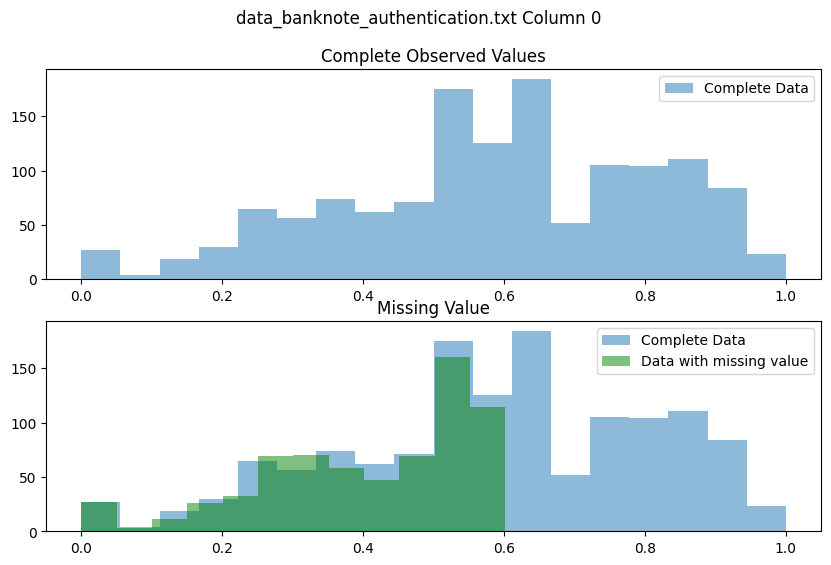

In [16]:
index = 1

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 2*3))
plt.suptitle("{} Column 0 ".format(dataset_file))

# 绘制 observed_values[:, 0] 的直方图
axs[0].hist(Data[:, index], alpha=0.5, bins="auto", density=False, label='Complete Data')
axs[0].set_title("Complete Observed Values")
axs[0].legend()

# 绘制 norm_observed_values[:, 0] 和 missing_value[:, 0] 的直方
axs[1].hist(Data[:, index], alpha=0.5, bins="auto", density=False, label='Complete Data')
axs[1].hist(masked_value[:, index], alpha=0.5, bins="auto", density=False, label='Data with missing value', color='green')
axs[1].set_title("Missing Value")
axs[1].legend()

In [186]:
#%% 1. Discriminator
if use_gpu is True:
    D_W1 = torch.tensor(utilityfuc.xavier_init([Dim*2, H_Dim1]),requires_grad=True, device="cuda")     # Data + Hint as inputs
    D_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True, device="cuda")

    D_W2 = torch.tensor(utilityfuc.xavier_init([H_Dim1, H_Dim2]),requires_grad=True, device="cuda")
    D_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True, device="cuda")

    D_W3 = torch.tensor(utilityfuc.xavier_init([H_Dim2, Dim]),requires_grad=True, device="cuda")
    D_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True, device="cuda")       # Output is multi-variate
else:
    D_W1 = torch.tensor(utilityfuc.xavier_init([Dim*2, H_Dim1]),requires_grad=True)     # Data + Hint as inputs
    D_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True)

    D_W2 = torch.tensor(utilityfuc.xavier_init([H_Dim1, H_Dim2]),requires_grad=True)
    D_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True)

    D_W3 = torch.tensor(utilityfuc.xavier_init([H_Dim2, Dim]),requires_grad=True)
    D_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True)       # Output is multi-variate

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

#%% 2. Generator
if use_gpu is True:
    G_W1 = torch.tensor(utilityfuc.xavier_init([Dim*2, H_Dim1]),requires_grad=True, device="cuda")     # Data + Mask as inputs (Random Noises are in Missing Components)
    G_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True, device="cuda")

    G_W2 = torch.tensor(utilityfuc.xavier_init([H_Dim1, H_Dim2]),requires_grad=True, device="cuda")
    G_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True, device="cuda")

    G_W3 = torch.tensor(utilityfuc.xavier_init([H_Dim2, Dim]),requires_grad=True, device="cuda")
    G_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True, device="cuda")
else:
    G_W1 = torch.tensor(utilityfuc.xavier_init([Dim*2, H_Dim1]),requires_grad=True)     # Data + Mask as inputs (Random Noises are in Missing Components)
    G_b1 = torch.tensor(np.zeros(shape = [H_Dim1]),requires_grad=True)

    G_W2 = torch.tensor(utilityfuc.xavier_init([H_Dim1, H_Dim2]),requires_grad=True)
    G_b2 = torch.tensor(np.zeros(shape = [H_Dim2]),requires_grad=True)

    G_W3 = torch.tensor(utilityfuc.xavier_init([H_Dim2, Dim]),requires_grad=True)
    G_b3 = torch.tensor(np.zeros(shape = [Dim]),requires_grad=True)

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

def generator(new_x,m):
    inputs = torch.cat(dim = 1, tensors = [new_x,m])  # Mask + Data Concatenate
    G_h1 = F.relu(torch.matmul(inputs, G_W1) + G_b1)
    G_h2 = F.relu(torch.matmul(G_h1, G_W2) + G_b2)   
    G_prob = torch.sigmoid(torch.matmul(G_h2, G_W3) + G_b3) # [0,1] normalized Output
    
    return G_prob

#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = torch.cat(dim = 1, tensors = [new_x,h])  # Hint + Data Concatenate
    D_h1 = F.relu(torch.matmul(inputs, D_W1) + D_b1)  
    D_h2 = F.relu(torch.matmul(D_h1, D_W2) + D_b2)
    D_logit = torch.matmul(D_h2, D_W3) + D_b3
    D_prob = torch.sigmoid(D_logit)  # [0,1] Probability Output
    
    return D_prob


def discriminator_loss(M, New_X, H):
    # Generator
    G_sample = generator(New_X,M)
    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)

    # Discriminator
    D_prob = discriminator(Hat_New_X, H)

    #%% Loss
    D_loss = -torch.mean(M * torch.log(D_prob + 1e-8) + (1-M) * torch.log(1. - D_prob + 1e-8))
    return D_loss


def generator_loss(X, M, New_X, H,kl_coef,info_coef):
    #%% Structure
    # Generator
    #kl_loss = torch.mean(torch.tensor([0,0,0]).float())
    G_sample = generator(New_X,M)

    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)

    # Discriminator
    D_prob = discriminator(Hat_New_X, H)

    #%% Loss
    G_loss1 = -torch.mean((1-M) * torch.log(D_prob + 1e-8))
    MSE_train_loss = torch.mean((M * New_X - M * G_sample)**2) / torch.mean(M)

    kl_loss = F.kl_div(F.log_softmax(New_X,1), F.softmax(G_sample,1))
    info_loss = utilityfuc.calculate_linfo(New_X,G_sample)

    G_loss = G_loss1 + alpha * MSE_train_loss + kl_coef * kl_loss + info_coef * info_loss

    #G_loss = G_loss1 + alpha * MSE_train_loss

    #%% MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return G_loss, MSE_train_loss, MSE_test_loss,kl_coef * kl_loss , info_coef * info_loss
    
def test_loss(X, M, New_X):
    #%% Structure
    # Generator
    G_sample = generator(New_X,M)

    #%% MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return MSE_test_loss, G_sample

In [187]:
#     Missing[:,i] = 1.*B

    
#%% Train Test Division    

def run(kl_coef,info_coef):
    rmse = []
    samples = []
    for i in range(5):
        idx = np.random.permutation(No)

        Train_No = int(No * train_rate)
        Test_No = No - Train_No
            
        # Train / Test Features
        trainX = Data[idx[:Train_No],:]
        testX = Data[idx[Train_No:],:]

        # Train / Test Missing Indicators
        trainM = Missing[idx[:Train_No],:]
        testM = Missing[idx[Train_No:],:]



        optimizer_D = torch.optim.Adam(params=theta_D)
        optimizer_G = torch.optim.Adam(params=theta_G)




        #%% Start Iterations

        train_losses = []
        test_losses = []
        train_kl = []
        train_info = []
        iterations = []

        for it in tqdm(range(5000)):    
            
            #%% Inputs
            mb_idx = utilityfuc.sample_idx(Train_No, mb_size)
            X_mb = trainX[mb_idx,:]  
            
            Z_mb = utilityfuc.sample_Z(mb_size, Dim) 
            M_mb = trainM[mb_idx,:]  
            H_mb1 = utilityfuc.sample_M(mb_size, Dim, 1-p_hint)
            H_mb = M_mb * H_mb1
            
            New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
            
            if use_gpu is True:
                X_mb = torch.tensor(X_mb, device="cuda")
                M_mb = torch.tensor(M_mb, device="cuda")
                H_mb = torch.tensor(H_mb, device="cuda")
                New_X_mb = torch.tensor(New_X_mb, device="cuda")
            else:
                X_mb = torch.tensor(X_mb)
                M_mb = torch.tensor(M_mb)
                H_mb = torch.tensor(H_mb)
                New_X_mb = torch.tensor(New_X_mb)
            
            optimizer_D.zero_grad()
            D_loss_curr = discriminator_loss(M=M_mb, New_X=New_X_mb, H=H_mb)
            D_loss_curr.backward()
            optimizer_D.step()
            
            optimizer_G.zero_grad()
            G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr, kl_loss, info_loss = generator_loss(X=X_mb, M=M_mb, New_X=New_X_mb, H=H_mb,kl_coef = kl_coef,info_coef = info_coef)
            #G_loss_curr.backward(retain_graph=True)
            G_loss_curr.backward()
            #(kl_loss + info_loss).backward()
            optimizer_G.step()    
                
            #%% Intermediate Losses
            if it % 100 == 0:
                # print('Iter: {}'.format(it),end='\t')
                # print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr.item())),end='\t')
                # print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr.item())))
                # print('KL_loss: {:.4}'.format(np.sqrt(kl_loss.item())),end='\t')
                # print('Info_loss: {:.4}'.format(np.sqrt(info_loss.item())),end='\t')


                    # Append the current iteration and losses to the lists
                iterations.append(it)
                train_losses.append(np.sqrt(MSE_train_loss_curr.item()))
                test_losses.append(np.sqrt(MSE_test_loss_curr.item()))
                train_kl.append(np.sqrt(kl_loss.item()))
                train_info.append(np.sqrt(info_loss.item()))


        Z_mb = utilityfuc.sample_Z(Test_No, Dim) 
        M_mb = testM
        X_mb = testX
                
        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce

        if use_gpu is True:
            X_mb = torch.tensor(X_mb, device='cuda')
            M_mb = torch.tensor(M_mb, device='cuda')
            New_X_mb = torch.tensor(New_X_mb, device='cuda')
        else:
            X_mb = torch.tensor(X_mb)
            M_mb = torch.tensor(M_mb)
            New_X_mb = torch.tensor(New_X_mb)
            
        MSE_final, Sample = test_loss(X=X_mb, M=M_mb, New_X=New_X_mb)
                
        print('Final Test RMSE: ' + str(np.sqrt(MSE_final.item())))

        rmse.append(np.sqrt(MSE_final.item()))
        samples.append([X_mb.detach().numpy(),M_mb.detach().numpy(),Sample.detach().numpy()])

    return rmse,samples

In [215]:
kl_coef = 0
info_coef = 100
name = "spam_{}_kl_{}_info_add".format(kl_coef, info_coef)

rmse,samples = run(kl_coef,info_coef)

  0%|          | 0/5000 [00:00<?, ?it/s]

Final Test RMSE: 0.1461729075846934


  0%|          | 0/5000 [00:00<?, ?it/s]

Final Test RMSE: 0.14144446537334365


  0%|          | 0/5000 [00:00<?, ?it/s]

Final Test RMSE: 0.13759071487527036


  0%|          | 0/5000 [00:00<?, ?it/s]

Final Test RMSE: 0.1407590196796097


  0%|          | 0/5000 [00:00<?, ?it/s]

Final Test RMSE: 0.14244068555635445


In [218]:
ks = []
for k in range(5):
    
    #fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 4*3))
    for i in range(4):
        imputed = samples[k][0] * (samples[k][1]) + samples[k][2] * (1- samples[k][1])
        # plt.suptitle("{}".format(name))
        # axs[i].hist(samples[k][0][:, i], alpha=0.5, bins="auto", density=False, label='Complete Data')
        # axs[i].hist(imputed[:, i], alpha=0.5, bins="auto", density=False, label='Data with imputed value', color='g')
        # sns.kdeplot(samples[k][0][:, i], ax=axs[i])
        # sns.kdeplot(imputed[:, i], ax=axs[i])
        # axs[i].set_title("Imputed Value")
        # axs[i].legend()
        # plt.savefig("{}_{}.png".format(name,k))
        #Kolmogorov-Smirnov
        ks.append(stats.ks_2samp(samples[k][0][:, i], imputed[:, i]).statistic)

        

In [219]:
try:
    # Open the file for appending (if it exists) or create it (if it doesn't exist)
    with open("result/0828_result.txt", "a") as file:
        # Write the new string and number to the file
        file.write(f"{name} | RMSE: {round(np.mean(rmse),5)}+-{round(np.std(rmse),5)} | KS: {round(np.mean(ks),5)}+-{round(np.std(ks),5)}\n")
        
    print("Data written to file.")

except FileNotFoundError:
    # Create a new file and write the string and number to it
    with open("result/0828_result.txt", "w") as file:
        file.write(f"{name} | RMSE: {round(np.mean(rmse),5)}+-{round(np.std(rmse),5)} | KS: {round(np.mean(ks),5)}+-{round(np.std(ks),5)}\n")
        
    print("File created and data written.")

Data written to file.
